In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
# plt.rcParams['ps.useafm'] = True
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import pandas as pd
import time
import shutil
import argparse
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import sys
# sys.path.append('/DATA/lucaa/software/CLoNe')

# from clone import CLoNe
# from plot import plot_clusters
# from structural_utils import load_md_args, show_cluster_info

import mdtraj
import pyemma

print(__doc__)
start = time.time()


def calculate_pca(topo, traj, main_folder, syst, at_sel, n_pca ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    

    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers

    # Principal component analysis
    original_coords = coords.copy()
    pca_obj = PCA(n_components=n_pca)
    reddim_coords = pca_obj.fit_transform(coords)
    eigenvalues = pca_obj.explained_variance_ratio_
    ratio = np.sum(eigenvalues[:n_pca])
    pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
    print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
    print("sum of Variance: %s"%(np.sum(eigenvalues)))
    with open("%sPCA_coords.txt"%output_folder, "w") as f:
        for x in range(n_pca):
            f.write("PC%i(%.2f) "%(x + 1, eigenvalues[x]))
        f.write("\n")
        for el in reddim_coords:
            for n in el:
                f.write("%f "%n)
            f.write("\n")  
    return pca_obj, reddim_coords, original_coords


def calc_magn_vector(pc):
    final_length = int(len(pc)/3)
    pc_magn = np.empty(final_length)
    
    for i in range(final_length):
        pc_magn[i] = np.sqrt(pc[i*3]**2+pc[i*3+1]**2+pc[i*3+2]**2)
    
    return pc_magn


def save_pc_bfact(init_padding, length_pc, final_padding, structure, pc_component, outpdb):

    pc_elongated = np.concatenate((np.zeros(init_padding),calc_magn_vector(pc_component),np.zeros(final_padding)))
    system_length_res = len([residue for residue in structure.topology.residues])
    system_length_atoms = len([ atom for atom in structure.topology.atoms])

    syst_bfact=np.zeros(system_length_atoms)
    index=0
    for resid in range(system_length_res):
        res_len = len(structure.topology.select('resid '+str(resid)))
        res_bfact= res_len
        syst_bfact[index:index+res_len] = pc_elongated[resid]
        index += res_len

    structure[0].save_pdb(outpdb, bfactors=syst_bfact*100)
    
# Check convercence PC
def calculate_pca_convergence(topo, traj, main_folder, syst, at_sel, n_pca, nframes, nsim ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    
    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers
    
    frameslist = np.multiply(np.arange(1,nsim+1),nframes)
    original_coords = coords.copy()
    pcas_list = []
    reddim_coords_list = []
    print(np.shape(coords))
    # Principal component analysis
    for section in frameslist:
        pca_obj = PCA(n_components=n_pca)
        
        reddim_coords = pca_obj.fit_transform(coords[0:section])
        pcas_list.append(pca_obj)
        #eigenvalues = pca_obj.explained_variance_ratio_
        #ratio = np.sum(eigenvalues[:n_pca])
        #pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
        #print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
        #print("sum of Variance: %s"%(np.sum(eigenvalues)))
  
    return pcas_list

Automatically created module for IPython interactive environment


In [4]:
# PARAMETERS SETUP

# Clustering parameters 
pdc=8   # neighbour search during clusterint
n_resize=4 
filt=0.1 
verbose=False
n_pca=10 # number of PC to include in calculations 
n_bins= 200  # number of bins for PC histz
# Simulations and topology 
trj_apo='apo/trjcat_md_pitpa_apo_center_pbcmol_fit_rot_trans_CA_after10ns_stride10.xtc'   # apo traj
trj_holo='holo/holo_prot.xtc'  # holo trajtrj_tot='pitpa_tot.xtc'   # concatenated total traj
trj_tot='pitpa_tot.xtc'
trj_mtot='p78l_holo.xtc'
trj_mtot_holo='apop_holop.xtc'

trj_mut='../pitpa_mutp78l/apo/trj_ca.xtc'

topom_apo='../pitpa_mutp78l/apo/apo_ca.gro'  # pdb or gro of apo

topo_apo='apo.gro'  # pdb or gro of apo

# Selection for PCA calculation (see mdtraj syntax)
at_sel="name CA and residue 5 to 259"  # try to exclude end loops or regions that move but are not interesting (hides the true PC)
n_res=254   # number of residues (still manual insertion, i know...)
feat="None"
resmin=5
resmax=259
output_folder = "results_holo_p78l"

apo_name="apo"
holo_name="holo"
mut_name="mut"
tot_name="tot"
mtot_name="mtot"

In [5]:
# make results folder 
try:
    os.mkdir(output_folder)
except FileExistsError:
    pass
# make images folder 
try:
    os.mkdir(output_folder+'/IMAGES/')
except FileExistsError:
    pass

# Calculate PCA
pca_apo, red_dim_coords_apo, orig_coords_apo = calculate_pca(topo_apo, trj_apo, output_folder, apo_name, at_sel, n_pca)
pca_holo, red_dim_coords_holo, orig_coords_holo = calculate_pca(topo_apo, trj_holo, output_folder, holo_name, at_sel, n_pca)
pca_mut, red_dim_coords_mut, orig_coords_mut = calculate_pca(topom_apo, trj_mut, output_folder, mut_name, at_sel, n_pca)
pca_mtot, red_dim_coords_mtot, orig_coords_mtot = calculate_pca(topom_apo, trj_mtot, output_folder, mtot_name, at_sel, n_pca)
pca_mtot_holo, red_dim_coords_mtot_holo, orig_coords_mtot_holo = calculate_pca(topom_apo, trj_mtot_holo, output_folder, mtot_name, at_sel, n_pca)
pca_tot, red_dim_coords_tot, orig_coords_tot = calculate_pca(topo_apo, trj_tot, output_folder, tot_name, at_sel, n_pca)

> PCA: 765 => 10 dimension(s) with eigenval.: [0.21311584 0.17041972 0.08972926 0.06452863 0.04868446 0.03032322
 0.02329631 0.02140839 0.01891111 0.01816203]
sum of Variance: 0.69857895
> PCA: 765 => 10 dimension(s) with eigenval.: [0.18920676 0.12391552 0.07535007 0.06882217 0.05147926 0.03279839
 0.03127985 0.02618908 0.02256922 0.02150059]
sum of Variance: 0.64311093
> PCA: 765 => 10 dimension(s) with eigenval.: [0.16681856 0.09564237 0.07293111 0.06331436 0.05448347 0.03997016
 0.03831302 0.03081724 0.02661007 0.02515366]
sum of Variance: 0.61405396
> PCA: 765 => 10 dimension(s) with eigenval.: [0.16210927 0.09453952 0.07003911 0.06074842 0.04433285 0.04252152
 0.03438016 0.03236967 0.02641306 0.02495749]
sum of Variance: 0.5924111
> PCA: 765 => 10 dimension(s) with eigenval.: [0.18513651 0.11345313 0.07938538 0.06138221 0.05065864 0.03433138
 0.02869129 0.02820229 0.02560488 0.021751  ]
sum of Variance: 0.6285967
> PCA: 765 => 10 dimension(s) with eigenval.: [0.16588974 0.1171794

# Figures PC and histograms checking that all pc apo, holo and tot are the similar 

In [6]:
# def read_xvg(fname):
#     data=[]
#     with open(fname) as f:
#         for line in f:
#             if not line.startswith(("@","#")):
#                 data.append(np.array([float(s) for s in line.split()]))
#     data=np.vstack(data)
#     return data

# #RMSF
# data = read_xvg("rmsf_apo.xvg")
# r, rmsf = data[:,0], data[:,1]
# rmsf_asterc = []
# # for i in range(6):
#     # rmsf_asterc.append(0)  
# for i in rmsf:
#     rmsf_asterc.append(i)
# # for i in range(24):
# #     rmsf_asterc.append(0)  

# def NormalizeData(z):
#     return (z - np.min(z)) / (np.max(z) - np.min(z))

# apor = NormalizeData(rmsf_asterc)

# data = read_xvg("rmsf_holo.xvg")
# r, rmsf = data[:,0], data[:,1]
# rmsf_asterc = []
# # for i in range(6):
#     # rmsf_asterc.append(0)  
# for i in rmsf:
#     rmsf_asterc.append(i)
# # for i in range(24):
# #     rmsf_asterc.append(0)  

# holor = NormalizeData(rmsf_asterc)

# data = read_xvg("rmsf_p71l.xvg")
# r, rmsf = data[:,0], data[:,1]
# rmsf_asterc = []
# # for i in range(6):
#     # rmsf_asterc.append(0)  
# for i in rmsf:
#     rmsf_asterc.append(i)
# # for i in range(24):
# #     rmsf_asterc.append(0)  

# mutr = NormalizeData(rmsf_asterc)

# fig, ax = plt.subplots(1,3, figsize=(11,3), sharey=True, sharex=True)
# tick_spacing = 20
# ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax[0].tick_params(axis='x', rotation=90)
# ax[1].tick_params(axis='x', rotation=90)
# ax[2].tick_params(axis='x', rotation=90)
# # ax[3].tick_params(axis='x', rotation=90)

# ax[0].set_xlim(resmin,resmax)
# ax[0].plot(np.arange(resmin, resmax+1),apor, linewidth=0.8, color='green')
# ax[1].plot(np.arange(resmin, resmax+1),holor, linewidth=0.8, color='dodgerblue')
# ax[2].plot(np.arange(resmin, resmax+1),mutr, linewidth=0.8, color='red')

# sns.despine()

# ax[0].legend(['Apo'], frameon=False)
# ax[1].legend(['Holo'], frameon=False)
# ax[2].legend(['Mut'], frameon=False)
# # ax[3].legend(['Apo+Holo+Mut'], frameon=False)


# ax[0].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[1].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[2].set_xlabel("Residue number", fontsize=12, labelpad=5)
# # ax[3].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[0].set_ylabel("RMSF (normalized)", fontsize=12, labelpad=5)
# fig.tight_layout()

# fig.savefig("comparison_rmsf_apo_holo_p71l.png", dpi=500, bbox_inches='tight')

# plt.show()

In [7]:
# apo = apor.flatten()
# holo = holor.flatten()
# mut1 = mutr.flatten()

# def NormalizeData(z):
#     return (z - np.min(z)) / (np.max(z) - np.min(z))

# def RMSD(xr,yr):
#     #Normalize
#     x = NormalizeData(xr)
#     y = NormalizeData(yr)
    
#     # Compute differences
#     differences = np.array(x) - np.array(y)

#     # Root Mean Square Deviation (RMSD)
#     return np.sqrt(np.mean(differences**2))

# ah = RMSD (apo,holo)

# print(f"RMSD Apo vs Holo: {ah}")

# mh1 = RMSD (mut1,holo)

# print(f"RMSD P71L vs Holo: {mh1}")

# ma1 = RMSD (mut1,apo)

# print(f"RMSD P71L vs Apo: {ma1}")

In [8]:
# fig, ax = plt.subplots(1,3, figsize=(10,3), sharey=True, sharex=True)
# tick_spacing = 20
# ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax[0].tick_params(axis='x', rotation=90)
# ax[1].tick_params(axis='x', rotation=90)
# ax[2].tick_params(axis='x', rotation=90)

# ax[0].set_xlim(resmin,resmax)
# ax[0].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_apo.components_[0]), linewidth=0.8, color='green')
# ax[1].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_holo.components_[0]), linewidth=0.8, color='dodgerblue')
# ax[2].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_mut.components_[0]), linewidth=0.8, color='red')

# sns.despine()

# ax[0].legend(['Apo'], frameon=False)
# ax[1].legend(['Holo'], frameon=False)
# ax[2].legend(['Mut'], frameon=False)

# ax[0].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[1].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[2].set_xlabel("Residue number", fontsize=12, labelpad=5)
# ax[0].set_ylabel("PC component (a.u.)", fontsize=12, labelpad=5)
# fig.tight_layout()

# # fig.savefig(output_folder+'/IMAGES/comparison_pc_apo_holo_mut.png',dpi=500,bbox_inches="tight")
# # fig.savefig(output_folder+'/IMAGES/comparison_pc_apo_holo_mut.pdf')

# plt.show()

In [9]:
# apo = calc_magn_vector(pca_apo.components_[0]).flatten()
# holo = calc_magn_vector(pca_holo.components_[0]).flatten()
# mut1 = calc_magn_vector(pca_mut.components_[0]).flatten()

# def NormalizeData(z):
#     return (z - np.min(z)) / (np.max(z) - np.min(z))

# def RMSD(xr,yr):
#     #Normalize
#     x = NormalizeData(xr)
#     y = NormalizeData(yr)
    
#     # Compute differences
#     differences = np.array(x) - np.array(y)

#     # Root Mean Square Deviation (RMSD)
#     return np.sqrt(np.mean(differences**2))

# ah = RMSD (apo,holo)

# print(f"RMSD Apo vs Holo: {ah}")

# mh1 = RMSD (mut1,holo)

# print(f"RMSD P71L vs Holo: {mh1}")

# ma1 = RMSD (mut1,apo)

# print(f"RMSD P71L vs Apo: {ma1}")

In [10]:
index_apo_end=np.shape(red_dim_coords_apo)[0]
index_tot_end=np.shape(red_dim_coords_tot)[0]

/tmp/ipykernel_18507/1162917055.py:30: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(['P78L','Holo'], frameon=False, fontsize=16, handles = legend_elements)


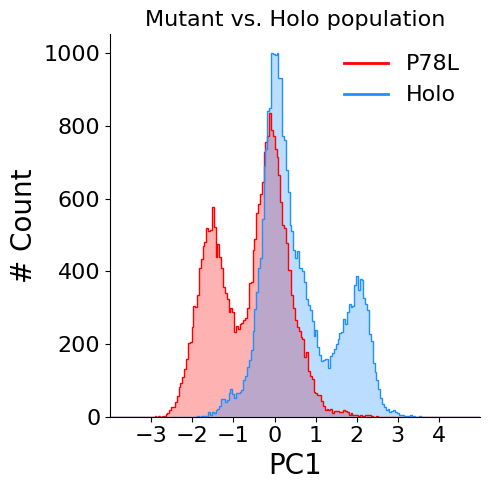

In [11]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

a = 'green'
h = 'dodgerblue'
m = 'red'

# ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

# ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_mtot[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_mtot[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_mtot[index_apo_end:index_tot_end,0], color=h, range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_mtot[index_apo_end:index_tot_end,0], color=h, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color=m, lw=2, label='P78L'),Line2D([0], [0], color=h, lw=2, label='Holo')]
ax.legend(['P78L','Holo'], frameon=False, fontsize=16, handles = legend_elements)

ax.set_title("Mutant vs. Holo population", fontsize=16)

fig.tight_layout()
# fig.savefig(output_folder+'/IMAGES/histograms_p78l_holo.pdf')
# fig.savefig(output_folder+'/IMAGES/histograms_p78l_holo.png',dpi=500,bbox_inches='tight')
plt.show()

/tmp/ipykernel_18507/3523701158.py:31: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(['Apo-P78L','Holo-P78L'], frameon=False, fontsize=16, handles = legend_elements)


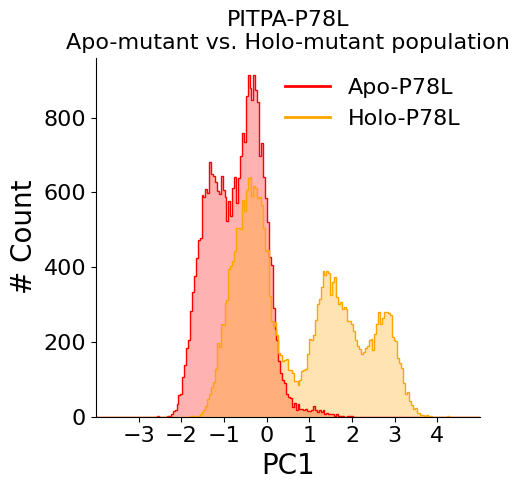

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

a = 'green'
h = 'dodgerblue'
m = 'red'
hm= 'orange'

# ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

# ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
# ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_mtot_holo[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_mtot_holo[0:index_apo_end,0], color=m, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_mtot_holo[index_apo_end:index_tot_end,0], color=hm, range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_mtot_holo[index_apo_end:index_tot_end,0], color=hm, range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color=m, lw=2, label='Apo-P78L'),Line2D([0], [0], color=hm, lw=2, label='Holo-P78L')]
ax.legend(['Apo-P78L','Holo-P78L'], frameon=False, fontsize=16, handles = legend_elements)

ax.set_title("PITPA-P78L\nApo-mutant vs. Holo-mutant population", fontsize=16)

fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/histograms_p78l_apoholo.pdf')
fig.savefig(output_folder+'/IMAGES/histograms_p78l_apoholo.png',dpi=500,bbox_inches='tight')
# plt.show()

In [14]:
import numpy as np
from scipy.stats import entropy

# Define two probability distributions (can be arrays, lists, or pandas Series)
p = np.array(red_dim_coords_tot[0:index_apo_end,0])
q = np.array(red_dim_coords_tot[index_apo_end:index_tot_end,0])

# Manually set bin edges
custom_bin_edges = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), num=400)

# Compute histograms to estimate the probability distributions
hist1, bin_edges1 = np.histogram(p, bins=custom_bin_edges, density=True)
hist2, bin_edges2 = np.histogram(q, bins=custom_bin_edges, density=True)

# Add a small constant to avoid zero values
epsilon = 1e-10
hist1 = hist1 + epsilon
hist2 = hist2 + epsilon

# Normalize distributions to ensure they sum to 1
hist1 /= np.sum(hist1)
hist2 /= np.sum(hist2)


# Compute KL divergence
kl_divergence1 = entropy(hist1, hist2)
kl_divergence2 = entropy(hist2, hist1)

kl_divergence = (kl_divergence1 + kl_divergence2) / 2

print(f"KL Divergence: {kl_divergence}")

KL Divergence: 1.4422773785791752


In [15]:
# Define two probability distributions (can be arrays, lists, or pandas Series)
p = np.array(red_dim_coords_mtot[0:index_apo_end,0])
q = np.array(red_dim_coords_mtot[index_apo_end:index_tot_end,0])

# Manually set bin edges
custom_bin_edges = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), num=400)

# Compute histograms to estimate the probability distributions
hist1, bin_edges1 = np.histogram(p, bins=custom_bin_edges, density=True)
hist2, bin_edges2 = np.histogram(q, bins=custom_bin_edges, density=True)

# Add a small constant to avoid zero values
# epsilon = 1e-10
hist1 = hist1 + epsilon
hist2 = hist2 + epsilon

# Normalize distributions to ensure they sum to 1
hist1 /= np.sum(hist1)
hist2 /= np.sum(hist2)


# Compute KL divergence
kl_divergence1 = entropy(hist1, hist2)
kl_divergence2 = entropy(hist2, hist1)

kl_divergence = (kl_divergence1 + kl_divergence2) / 2

print(f"KL Divergence P71L: {kl_divergence}")

KL Divergence P71L: 2.6239594396754136


In [16]:
# Define two probability distributions (can be arrays, lists, or pandas Series)
p = np.array(red_dim_coords_mtot_holo[0:index_apo_end,0])
q = np.array(red_dim_coords_mtot_holo[index_apo_end:index_tot_end,0])

# Manually set bin edges
custom_bin_edges = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), num=400)

# Compute histograms to estimate the probability distributions
hist1, bin_edges1 = np.histogram(p, bins=custom_bin_edges, density=True)
hist2, bin_edges2 = np.histogram(q, bins=custom_bin_edges, density=True)

# Add a small constant to avoid zero values
# epsilon = 1e-10
hist1 = hist1 + epsilon
hist2 = hist2 + epsilon

# Normalize distributions to ensure they sum to 1
hist1 /= np.sum(hist1)
hist2 /= np.sum(hist2)


# Compute KL divergence
kl_divergence1 = entropy(hist1, hist2)
kl_divergence2 = entropy(hist2, hist1)

kl_divergence = (kl_divergence1 + kl_divergence2) / 2

print(f"KL Divergence P71L Apo-Holo: {kl_divergence}")

KL Divergence P71L Apo-Holo: 4.2060211291629805


# Clustering


In [5]:
clone_apo = CLoNe(pdc=pdc)
clone_holo = CLoNe(pdc=pdc)
clone_apoholo = CLoNe(pdc=12)

#clone_apo.fit(red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1)) 
#clone_holo.fit(red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1)) 
clone_apoholo.fit(red_dim_coords_tot[:,0].reshape(-1, 1))   

# Population analysis

In [7]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in clusters:
    
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:index_tot_end] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100])
    #print(label, count_apo, count_holo, count_tot)

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)'])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

NameError: name 'index_apo_end' is not defined

# Cluster plots

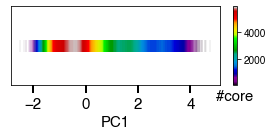

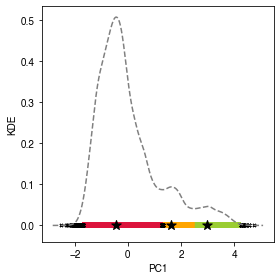

In [7]:
pca_headers = ["PC%i"%(x + 1) for x in range(n_pca)]
#plot_clusters(clone_apo, red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1), output_folder+'/apo_1',pca_headers[:2] ) 
#plot_clusters(clone_holo, red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1), output_folder+'/holo_1',pca_headers[:2] )
plot_clusters(clone_apoholo, red_dim_coords_tot[:,0].reshape(-1, 1), output_folder+'/'+tot_name+'_1',pca_headers[:2] )

# Save clusters

In [9]:
# Load trajectories
#struct_apo = mdtraj.load(trj_apo, top=topo_apo)
#struct_holo = mdtraj.load(trj_holo, top=topo_apo)
struct_apoholo = mdtraj.load(trj_tot, top=topo_apo)

In [12]:
unique_labels = range(len(clone_apoholo.centers)) 
folder = output_folder+'/'+tot_name+'_1'

# Save center
[struct_apoholo[center].save(folder+"/Center_%d.pdb"%(center_id + 1)) for center, center_id in zip(clone_apoholo.centers, unique_labels)]
# Save trajs
[struct_apo[clone_apoholo.labels_[0:index_apo_end] == lab].save(folder+"/Cluster_apo_%d.xtc"%(lab + 1)) for lab in unique_labels]
[struct_holo[clone_apoholo.labels_[index_apo_end:] == lab].save(folder+"/Cluster_holo_%d.xtc"%(lab + 1)) for lab in unique_labels]

[None, None, None]

# Save extreme structures

In [10]:
minframe=[100,-1,-2]
maxframe=[-100,-1,-2]
for frame in zip(red_dim_coords_tot[:,0].reshape(-1, 1), clone_apoholo.labels_, range(len(clone_apoholo.labels_))):
    if frame[1] != -1:
        if frame[0] < minframe[0]:
            minframe = frame
        if frame[0] > maxframe[0]:
            maxframe = frame

folder = output_folder+'/'+tot_name+'_1'
struct_apoholo[minframe[2]].save(folder+"/extremeleft.pdb")          
struct_apoholo[maxframe[2]].save(folder+"/extremeright.pdb")          


In [12]:
a = sorted(zip(red_dim_coords_tot[:,0].reshape(-1, 1), clone_apoholo.labels_, range(len(clone_apoholo.labels_))))
a = [el for el in a if el[1] != -1]
a[0]
struct_apoholo[a[0][2]].save(folder+"/extremeleft1.pdb")
struct_apoholo[a[1][2]].save(folder+"/extremeleft2.pdb")
struct_apoholo[a[2][2]].save(folder+"/extremeleft3.pdb")
struct_apoholo[a[3][2]].save(folder+"/extremeleft4.pdb")
struct_apoholo[a[4][2]].save(folder+"/extremeleft5.pdb")
struct_apoholo[a[5][2]].save(folder+"/extremeleft6.pdb")
struct_apoholo[a[6][2]].save(folder+"/extremeleft7.pdb")
struct_apoholo[a[7][2]].save(folder+"/extremeleft8.pdb")
struct_apoholo[a[8][2]].save(folder+"/extremeleft9.pdb")
struct_apoholo[a[9][2]].save(folder+"/extremeleft10.pdb")
struct_apoholo[a[10][2]].save(folder+"/extremeleft11.pdb")
struct_apoholo[a[11][2]].save(folder+"/extremeleft12.pdb")
struct_apoholo[a[12][2]].save(folder+"/extremeleft13.pdb")
struct_apoholo[a[13][2]].save(folder+"/extremeleft14.pdb")
struct_apoholo[a[14][2]].save(folder+"/extremeleft15.pdb")
struct_apoholo[a[15][2]].save(folder+"/extremeleft16.pdb")
struct_apoholo[a[16][2]].save(folder+"/extremeleft17.pdb")
struct_apoholo[a[17][2]].save(folder+"/extremeleft18.pdb")
struct_apoholo[a[18][2]].save(folder+"/extremeleft19.pdb")
struct_apoholo[a[19][2]].save(folder+"/extremeleft20.pdb")

struct_apoholo[a[-1][2]].save(folder+"/extremeright1.pdb")
struct_apoholo[a[-2][2]].save(folder+"/extremeright2.pdb")
struct_apoholo[a[-3][2]].save(folder+"/extremeright3.pdb")
struct_apoholo[a[-4][2]].save(folder+"/extremeright4.pdb") 
struct_apoholo[a[-5][2]].save(folder+"/extremeright5.pdb")
struct_apoholo[a[-6][2]].save(folder+"/extremeright6.pdb")
struct_apoholo[a[-7][2]].save(folder+"/extremeright7.pdb")
struct_apoholo[a[-8][2]].save(folder+"/extremeright8.pdb")
struct_apoholo[a[-9][2]].save(folder+"/extremeright9.pdb")
struct_apoholo[a[-10][2]].save(folder+"/extremeright10.pdb")
struct_apoholo[a[-11][2]].save(folder+"/extremeright11.pdb")
struct_apoholo[a[-12][2]].save(folder+"/extremeright12.pdb")
struct_apoholo[a[-13][2]].save(folder+"/extremeright13.pdb")
struct_apoholo[a[-14][2]].save(folder+"/extremeright14.pdb") 
struct_apoholo[a[-15][2]].save(folder+"/extremeright15.pdb")
struct_apoholo[a[-16][2]].save(folder+"/extremeright16.pdb")
struct_apoholo[a[-17][2]].save(folder+"/extremeright17.pdb")
struct_apoholo[a[-18][2]].save(folder+"/extremeright18.pdb")
struct_apoholo[a[-19][2]].save(folder+"/extremeright19.pdb")
struct_apoholo[a[-20][2]].save(folder+"/extremeright20.pdb")

 # Save  PC in B-fact

In [15]:
folder = output_folder
save_pc_bfact(3,254,11,struct_apo, pca_apo.components_[0],folder+"/IMAGES/pitpa_apo_pc0.pdb")
save_pc_bfact(3,254,11,struct_apo, pca_holo.components_[0],folder+"/IMAGES/pitpa_holo_pc0.pdb")
save_pc_bfact(3,254,11,struct_apo, pca_tot.components_[0],folder+"/IMAGES/pitpa_apoholo_pc0.pdb")

2 44.55226115603474 55.451732055505644 85.17567429679262 37.94768885412061 47.23138668752763
1 75.22754254056193 24.77245745943807 8.594945750144554 6.465766470528213 2.1291792796163396
0 99.62453066332915 0.37546933667083854 5.435189279276216 5.414781810142512 0.020407469133702935
-1 21.72043010752688 78.27956989247312 0.7907894289309887 0.17176286520866638 0.6190265637223223


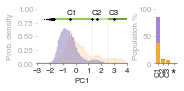

In [9]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in [2,1,0,-1]:
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:58800] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100, count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_), count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_)])
    print(label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100,count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_),count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_) )

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)', 'weighted_cluster_relevance_apo','weighted_cluster_relevance_holo', ])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

from itertools import islice, cycle
import statsmodels.api as sm
import matplotlib.cm as cm
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(2.5,1), )
plt.subplots_adjust(wspace=0.5)
color_list = np.array(['#68a92e','#bbe398','#88ce4b'])
colors = np.array(list(islice(cycle(color_list),len(clone_apoholo.centers))))
min_pc = -3
max_pc = 4
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}


centers = np.array(clone_apoholo.centers)
labels = np.array(clone_apoholo.labels_)
labels_all = np.array(clone_apoholo.labels_all)
core = clone_apoholo.core_card

sns.despine(left=True)
#PLOT 1 
ax1.set_xlim([min_pc,max_pc])
ax1.set_ylim([0,1])
ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
ax1.set_yticks([0,0.25,0.5,0.75, 1])
ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel("Prob. density", fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor2)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor2)  
ax1.spines['left'].set_color(axcolor2)
ax1.spines['bottom'].set_color(axcolor)  
    
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2,  alpha=0.5)
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.2, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.6, density=True, linewidth=0.2)
    
# Mask for plotting
assigned_mask = np.where(labels != -1)
outliers_mask = np.where(labels == -1)

# Sort some values for better visualization after
data = red_dim_coords_tot[:,0].reshape(-1, 1)
arcore = np.argsort(core)
s_cores = core[arcore]
s_x = data[arcore]

ypos=[0.82]
# Plot clusters
ax1.axvline(x=1.3, color='#AAAAAA', linestyle='--', ymax=0.8, linewidth=0.2, zorder=-1)
ax1.axvline(x=2.55, color='#AAAAAA', linestyle='--', ymax=0.8, linewidth=0.2, zorder=-1)

ax1.scatter(data[assigned_mask, 0], ypos * len(data[assigned_mask]), marker='|', s=3, color=colors[labels[assigned_mask]], zorder=1, clip_on=True)
ax1.scatter(data[outliers_mask, 0], ypos * len(data[outliers_mask]), marker='D', s=0.05, color='black', zorder=1, clip_on=True)
ax1.scatter(data[centers, 0], ypos * len(data[centers]), marker='D', s=2, color='black', zorder=1, clip_on=True)

ax1.text(-0.75,0.9, "C1", fontsize=8)
ax1.text(1.25,0.9, "C2", fontsize=8)
ax1.text(2.58,0.9, "C3", fontsize=8)

    
    
#PLOT 2 
ax2.set_ylim([0,100])
ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
#ax2.set_xlabel("Clusters", fontsize=20, labelpad=5)
ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor2)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor2)
ax2.spines['left'].set_color(axcolor2)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


new_df = df[['weighted_cluster_relevance_apo','weighted_cluster_relevance_holo']]
new_df.plot(kind='bar', legend=False, width=0.8, ax=ax2, color=['#faa336','#a782d9','black'], stacked=True)

ax2.set_xticklabels(["C1","C2", "C3",""], rotation = 90, ha='center',**hfont, fontsize=8)
ax2.text(3.01,-28,'*', ha='center', fontsize=14, color=axcolor)


#fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/total_figure.png', dpi=600, bbox_inches='tight')



0 99.62453066332915 0.37546933667083854 5.435189279276216 5.414781810142512 0.020407469133702935
1 75.20792079207921 24.792079207920793 8.588143260433318 6.458963980816979 2.1291792796163396
2 44.55358568918703 55.450407283181605 85.18077616407605 37.95109009897622 47.233087309955444
-1 22.103004291845494 77.8969957081545 0.7924900513587972 0.17516411006428353 0.6173259412945138


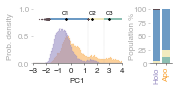

In [22]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in [0,1,2,-1]:
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:58800] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100, count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_), count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_)])
    print(label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100,count_apo/count_tot*100*count_tot/len(clone_apoholo.labels_),count_holo/count_tot*100*count_tot/len(clone_apoholo.labels_) )

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)', 'weighted_cluster_relevance_apo','weighted_cluster_relevance_holo', ])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

from itertools import islice, cycle
import statsmodels.api as sm
import matplotlib.cm as cm
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(2.5,1), )
plt.subplots_adjust(wspace=0.5)
color_list = np.array(['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"])
colors = np.array(list(islice(cycle(color_list),len(clone_apoholo.centers))))
min_pc = -3
max_pc = 4
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}


centers = np.array(clone_apoholo.centers)
labels = np.array(clone_apoholo.labels_)
labels_all = np.array(clone_apoholo.labels_all)
core = clone_apoholo.core_card

sns.despine(left=True)
#PLOT 1 
ax1.set_xlim([min_pc,max_pc])
ax1.set_ylim([0,1])
ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
ax1.set_yticks([0,0.5, 1])
ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel("Prob. density", fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor2)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor2)  
ax1.spines['left'].set_color(axcolor2)
ax1.spines['bottom'].set_color(axcolor)  
    
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2,  alpha=0.5)
ax1.hist(red_dim_coords_tot[0:index_apo_end,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.5, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.6, density=True, linewidth=0.2)
    
# Mask for plotting
assigned_mask = np.where(labels != -1)
outliers_mask = np.where(labels == -1)

# Sort some values for better visualization after
data = red_dim_coords_tot[:,0].reshape(-1, 1)
arcore = np.argsort(core)
s_cores = core[arcore]
s_x = data[arcore]

ypos=[0.82]
# Plot clusters
ax1.axvline(x=1.3, color='#AAAAAA', linestyle='--', ymax=0.8, linewidth=0.2, zorder=-1)
ax1.axvline(x=2.55, color='#AAAAAA', linestyle='--', ymax=0.8, linewidth=0.2, zorder=-1)

ax1.scatter(data[assigned_mask, 0], ypos * len(data[assigned_mask]), marker='|', s=3, color=colors[labels[assigned_mask]], zorder=1, clip_on=True)
ax1.scatter(data[outliers_mask, 0], ypos * len(data[outliers_mask]), marker='D', s=0.05, color=color_list[3], zorder=1, clip_on=True)
ax1.scatter(data[centers, 0], ypos * len(data[centers]), marker='D', s=2, color='black', zorder=1, clip_on=True)

ax1.text(-0.75,0.9, "C1", fontsize=6)
ax1.text(1.35,0.9, "C2", fontsize=6)
ax1.text(2.68,0.9, "C3", fontsize=6)

    
    
#PLOT 2 
ax2.set_ylim([0,50])
ax2.set_yticks([0,12.5,25,37.5,50])
ax2.set_yticklabels([0,25,50,75,100])
ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
#ax2.set_xlabel("Clusters", fontsize=20, labelpad=5)
ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor2)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor2)
ax2.spines['left'].set_color(axcolor2)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


new_df = df[['weighted_cluster_relevance_holo','weighted_cluster_relevance_apo', ]]
new_df.transpose().plot(kind='bar', legend=False, width=0.8, ax=ax2, color=color_list, stacked=True)

ax2.set_xticklabels(["Holo", "Apo"], rotation = 90, ha='center',**hfont, fontsize=8)
ax2.get_xticklabels()[0].set_color("#998EC3")
ax2.get_xticklabels()[1].set_color("#FAA336")


#fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/total_figure.png', dpi=600, bbox_inches='tight')



(5881,)
(5881,)


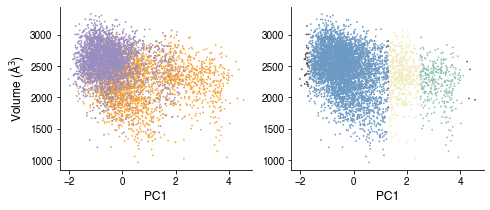

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(7.6,3), )

sns.despine()
vol = np.loadtxt('pocket/mdpout_descriptors.txt', skiprows=1, unpack=True)
lab = clone_apoholo.labels_[::10]
print(np.shape(vol[0]))
print(np.shape(lab))
#plt.scatter(lab, vol[1], s=0.01)
colorlist= ['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"]
lab = [colorlist[0] if x==0 else x for x in lab]
lab = [colorlist[1] if x==1 else x for x in lab]
lab = [colorlist[2] if x==2 else x for x in lab]
lab = [colorlist[-1] if x==-1 else x for x in lab]
#lab
ax1.set_xlabel('PC1', fontsize=12)
ax2.set_xlabel('PC1', fontsize=12)
ax1.set_ylabel('Volume (\u212b$^3$)', fontsize=12)

ax1.scatter(red_dim_coords_tot[::10,0], vol[1], s=0.5, c=['#FAA336']*2940+['#998EC3']*2941)
ax2.scatter(red_dim_coords_tot[::10,0], vol[1], s=0.5, c=lab)

fig.savefig(output_folder+'/IMAGES/volume.png', dpi=600, bbox_inches='tight')


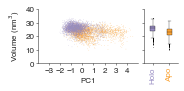

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(2.5,1),sharey=True)
plt.subplots_adjust(wspace=0.1)
color_list = np.array(['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"])
colors = np.array(list(islice(cycle(color_list),len(clone_apoholo.centers))))
min_pc = -3
max_pc = 4
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}


sns.despine(left=False)
#PLOT 1 
ax1.set_xlim([-4,5])
ax1.set_ylim([0,4000])
ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
ax1.set_yticks([0,1000,2000,3000,4000])
ax1.set_yticklabels([0,10,20,30,40])

ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel('Volume (nm$^3$)', fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor)  
ax1.spines['left'].set_color(axcolor)
ax1.spines['bottom'].set_color(axcolor)  
    
colorlist= ['#8CBEB2','#F2EBBF','#6C9AC4', "#5C4B51"]

ax1.scatter(red_dim_coords_tot[::10,0], vol[1], c=['#FAA336']*2941+['#998EC3']*2940, marker='o', s=0.2, linestyle='None',edgecolors=None, linewidths=0 )
    
    
#PLOT 2 
#ax2.set_ylim([0,50])
#ax2.set_yticks([])
#ax2.set_yticklabels([0,25,50,75,100])
#ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
#ax2.set_xlabel("Clusters", fontsize=20, labelpad=5)
#ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor)
ax2.spines['left'].set_color(axcolor)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


ax2.set_xticklabels(["Holo", "Apo"], rotation = 90, ha='center',**hfont, fontsize=8)
ax2.get_xticklabels()[0].set_color("#998EC3")
ax2.get_xticklabels()[1].set_color("#FAA336")


vol = np.loadtxt('pocket/mdpout_descriptors.txt', skiprows=1, unpack=True)
color = dict(boxes='black', whiskers='black', medians='red', caps='black')
data=[vol[1,2940:],vol[1,0:2940]]

boxprops = dict(linestyle='-', linewidth=0.3, color='black')
flierprops = dict(marker='o', markerfacecolor='black', linewidth=0.2, markersize=0.5, fillstyle='full', markeredgewidth=0.0)
medianprops = dict(linestyle='-', linewidth=0.3, color='black')
#meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
#meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
whiskerprops = dict(linestyle='-',linewidth=0.3, color='black')
capprops = dict(linewidth=0.3, color='black')


bp = ax2.boxplot(data, widths=0.3,patch_artist=True,
            flierprops=flierprops, 
            whiskerprops = whiskerprops,
            boxprops=boxprops,
            medianprops=medianprops,
            capprops=capprops)

colors=['#998EC3','#FAA336']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

fig.savefig(output_folder+'/IMAGES/volume_figure.png', dpi=600, bbox_inches='tight')